### Refs
- [RDKit Documentation](https://www.rdkit.org/docs/GettingStartedInPython.html)
- [PubChem](https://pubchem.ncbi.nlm.nih.gov/) - find SDF files for molecules
- [YouTube Tutorial](https://www.youtube.com/watch?v=NozaWUkJ3YM)

### Workflow Suggestions
> After modifying classes from `src` directory, **Restart NoteBook Kernel** is required 
- Recommended action after changing files in `src`: Restart -> Run All

## Imports

In [3]:
from src.core.compound import MBCompound
from src.loader import MBLoader
from src.utils.renderer import Renderer
from src.utils.ui import Theme
from src import DIAMAG_COMPOUND_ATOMS_SUBDIR


## RDkit Diamag Calcs


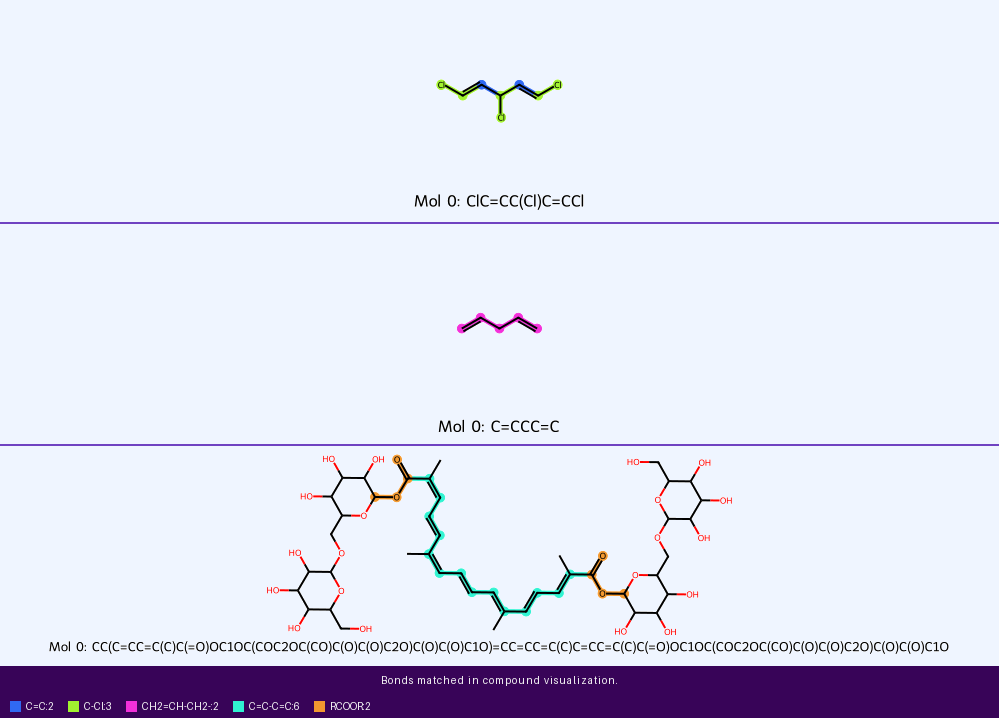

In [4]:
from collections import Counter
from typing import DefaultDict
from collections import defaultdict

from src.constants.bond_types import RELEVANT_BOND_TYPES
from src.loader import MBLoader, MBMolecule
from tests.core.bond_match.bond_match_test_data import BOND_MATCH_TEST_CASES

failures: list[str] = []

mols: list[MBMolecule] = []
highlightAtomLists: list[list[int]] = []
highlightAtomGroupsPerMol: list[dict[str, list[int]]] = []
matches_counters: list[Counter[str]] = []


for idx, bond_type_test in enumerate(BOND_MATCH_TEST_CASES):
    matches_counter: Counter[str] = Counter()
    mol: MBMolecule = MBLoader.MolFromSmiles(smiles=bond_type_test.SMILES)
    mols.append(mol)

    # Collect highlight atoms for this molecule (flat union) + per-formula atom groups (NEW)
    atoms_to_highlight: set[int] = set()
    groups_atoms: dict[str, set[int]] = defaultdict(set)  # formula -> atoms

    for relevant_bond_type in RELEVANT_BOND_TYPES:
        smarts = relevant_bond_type.SMARTS
        hits = mol.GetSubstructMatches(smarts=smarts)  # tuple[tuple[int,...],...]

        if hits:
            matches_counter[relevant_bond_type.formula] += len(hits)
            for hit in hits:
                atoms_to_highlight.update(hit)  # union (kept)
                groups_atoms[relevant_bond_type.formula].update(hit)  # NEW: keep grouping

    highlightAtomLists.append(sorted(atoms_to_highlight))
    highlightAtomGroupsPerMol.append({k: sorted(v) for k, v in groups_atoms.items()})  # NEW
    matches_counters.append(matches_counter)

# Render: highlightAtomLists length == len(mols)
display(
    Renderer(Theme.LoFi).GetMoleculesGridImg(
        mols=[m.ToRDKit() for m in mols],
        highlightAtomLists=highlightAtomLists,
        highlightAtomGroupsPerMol=highlightAtomGroupsPerMol,
        matchesCountersPerMol=matches_counters,
        size=(999,222,),
        mols_per_row=1,
        label='Bonds matched in compound visualization.',
        showLegend=True,
    )
)

